# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 006


## Due: October 13, 2022

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing your own loss function (**without asking me or the TAs what you should choose**), repeating (d).

f) Now try with three inputs, generating your own training and testing data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a test set in the same manner as the training set, classify the samples, and compute the classification accuracy.

g) Using your data from HW1 or any new data you curate if you don't think your HW1 data is appropriate for this assighnment, train your MLP using your training set (80%). Compute the error rate on your test set (20%). It's up to you how many hidden units to use. 

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 65%, e=10%, f=5%, g=20%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,1.046199,1.158495,0.0
1,0.940761,-0.064862,1.0
2,1.034341,0.798367,0.0
3,0.852726,1.016493,0.0
4,0.761780,-0.004878,1.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

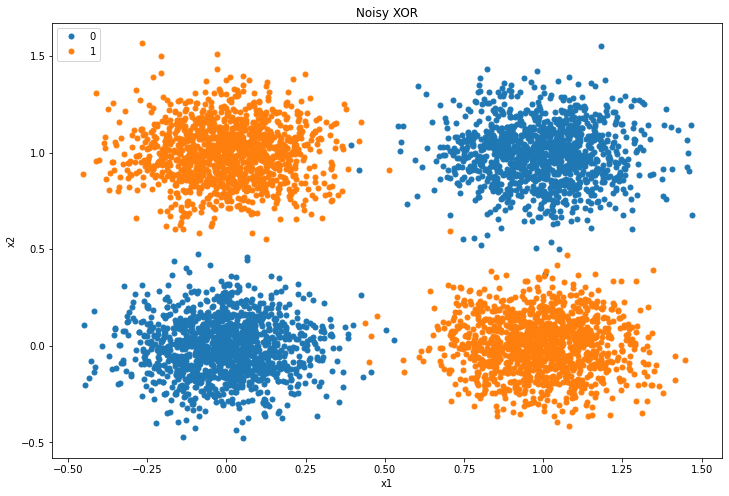

In [5]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

In [6]:
# ReLU function
def relu(v):
    v[v < 0] = 0
    return v

# Sigmoid function
def sigmoid(v):
    return 1.0/(1.0 + np.exp(-v))

# Safe logarithm (take absolute value and add a small positive number)
def log_eps(x):
  return np.log(np.abs(x) + 0.0001)

# Softplus loss function
def softplus(y_true, y_pred):
    r = np.multiply(1.0 - 2.0*y_true, y_pred)
    return np.mean(log_eps(1.0 + np.exp(r)))

# Categorical cross-entropy loss function
def cce(y_true, y_pred):
    L = - np.multiply(y_true, log_eps(sigmoid(y_pred)))
    L = L - np.multiply(1 - y_true, log_eps(1.0 - sigmoid(y_pred)))
    return np.mean(L)

# Mean squared logarithmic error loss function
def msle(y_true, y_pred):
    D = np.log(1.0 + y_true) - np.log(1.0 + y_pred)
    return np.mean(np.square(D))

# Function for splitting data into training and testing sets
def split_data(X, y, batch_size, test_split = 0.2):
    # Compute the size of the training set
    n = X.shape[0]
    test_n = int((test_split * n) // 1)

    # Generate the indices for the test and training sets
    test_idx = np.random.choice(np.arange(n), test_n, replace = False)
    train_idx = [x for x in np.arange(n) if x not in test_idx]

    # Return the training and test data
    train_X, train_y = X[train_idx, ::], y[train_idx, ::]
    test_X, test_y = X[test_idx, ::], y[test_idx, ::]
    return train_X, train_y, test_X, test_y

In [7]:
class Network():
    def __init__(self, input_layers = 2, hidden_layers = 3, learning_rate = 0.1,
                 loss_function = softplus, batch_size = 50):

        # Network specifications
        self.input_layers = input_layers
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.loss_function = loss_function
        self.batch_size = batch_size
                
        # Weights
        weight_in = np.random.rand(self.hidden_layers, self.input_layers)
        weight_out = np.random.rand(1, self.hidden_layers)
        self.weights = [weight_in, weight_out]

        # Biases
        bias_in = np.zeros((self.hidden_layers, 1))
        bias_out = 0
        self.bias = [bias_in, bias_out]
    
    # Feedforward for a batch
    def forward(self, X):
        h_prop = []
        y_prop = []

        for idx in range(X.shape[0]):
            x_batch = X[idx, ::]
            x_batch = x_batch.reshape(self.input_layers, 1)
            
            h = np.dot(self.weights[0], x_batch) + self.bias[0]
            h = relu(h)
            h_prop.append(h)

            y = np.dot(self.weights[1], h) + self.bias[1]
            y_prop.append(y)
            
        return np.array(y_prop), np.array(h_prop)
        
    # Backpropagation for a batch
    def backward(self, X, y, h_prop, y_prop):  
        # Initialize lists  
        gradient_weight_in = []
        gradient_weight_out = []
        gradient_bias_in = []
        gradient_bias_out = []

        for idx in range(X.shape[0]):
            # Get batch data
            x_batch = X[idx, ::]
            x_batch = x_batch.reshape(self.input_layers, 1)
            
            # Output layer
            r = 1.0 - 2*y[idx]
            gradient_bias_out_value = sigmoid(r * y_prop[idx]) * r
            gradient_bias_out.append(gradient_bias_out_value)
            gradient_weight_out.append(np.multiply(gradient_bias_out_value, h_prop[idx]))
            
            # Input layer
            gradient_bias_in_value = gradient_bias_out_value * self.weights[1]
            gradient_bias_in_value = gradient_bias_in_value.T
            gradient_bias_in_value[np.where(h_prop[idx] <= 0)] = 0
            gradient_bias_in.append(gradient_bias_in_value)
            gradient_weight_in.append(np.dot(gradient_bias_in_value, x_batch.T))           
            
        # Update weights and biases
        self.weights[0] -= (self.learning_rate * np.mean(gradient_weight_in))
        self.weights[1] -= (self.learning_rate * np.mean(gradient_weight_out))
        self.bias[0] -= (self.learning_rate * np.mean(gradient_bias_in))
        self.bias[1] -= (self.learning_rate * np.mean(gradient_bias_out))        
        
    # Predict labels
    def predict(self, X):
        y_pred, h_prop = self.forward(X)
        y_pred[y_pred >= 0] = 1
        y_pred[y_pred < 0] = 0
        return y_pred
    
    # Compute accuracy
    def accuracy(self, X, y):
        y_pred = self.predict(X).reshape(-1, 1)
        return 100.0 * np.sum(y == y_pred) / len(y)

    # Train the network against a training data set
    def train(self, X, y, epochs = 10):
        n = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle the indices        
            idx = np.arange(n)
            np.random.shuffle(idx)

            # Initialize the loss and accuracy record for the batches
            loss = []
            acc = []

            for i in range(0, n, self.batch_size):
                # Get batch data
                batch_idx = idx[i:i + self.batch_size]
                batch_X = X[batch_idx, ::]
                batch_y = y[batch_idx, ::]
                
                # Forward propagation and loss
                y_prop, h_prop = self.forward(batch_X)
                L = self.loss_function(batch_y, y_prop.reshape(self.batch_size, 1))
                loss.append(L)

                # Accuracy
                A = self.accuracy(batch_X, batch_y)
                acc.append(A)

                # Do backward propagation and update weights
                self.backward(batch_X, batch_y, h_prop, y_prop)
            
            # Print performance for this epoch
            print(f'Training epoch {(epoch + 1):d} of {epochs:d} (loss: {np.mean(loss):.4f}, accuracy: {np.mean(acc):.4f})')
        
        # Return the accuracy and loss for the last epoch
        return acc, loss

    # Test the network against a test set
    def test(self, X, y):
        n = X.shape[0]
        idx = np.arange(n)

        # Initialize the loss and accuracy record for the batches
        loss = []
        acc = []

        for i in range(0, n, self.batch_size):
            # Get batch data
            batch_idx = idx[i:i + self.batch_size]
            batch_X = X[batch_idx, :]
            batch_y = y[batch_idx, ::]

            # Forward propagation and loss
            y_prop, h_prop = self.forward(batch_X)
            L = self.loss_function(batch_y, y_prop.reshape(self.batch_size, 1))
            loss.append(L)

            # Accuracy
            A = self.accuracy(batch_X, batch_y)
            acc.append(A)

            # Status update
            print(f'Testing batch {(i + 1):d} of {n:d} (loss: {L:.4f}, accuracy: {A:.4f})')

        # Overall testing performance
        print(f'Testing complete (loss: {np.mean(loss):.4f}, accuracy: {np.mean(acc):.4f})')
        
        return acc, loss

    # Define decision boundary
    def plot_boundary(self):
        # Only valid for two input layers
        if (self.input_layers > 2):
            return

        # Axis
        n = 200
        idx = np.linspace(-0.5, 1.5, n)

        # Create a grid
        x1, x2 = np.meshgrid(idx, idx)
        X = np.zeros((n*n, 2))
        X[:, 0] = x1.flatten()
        X[:, 1] = x2.flatten()

        # Run the network on each point in the grid
        y_prob = self.predict(X)

        # Plot the results
        fig, ax = plt.subplots(figsize=(12,8))
        ax.margins(0.05)
        indices_0 = [k for k in range(0, X.shape[0]) 
                    if y_prob[k, ::] <= 0.5]
        indices_1 = [k for k in range(0, X.shape[0]) 
                    if y_prob[k, ::] > 0.5]
        ax.plot(X[indices_0, 0], X[indices_0, 1], 
                'C0', marker='o', linestyle='', ms=5, label='0')
        ax.plot(X[indices_1, 0], X[indices_1, 1], 
                'C1', marker='o', linestyle='', ms=5, label='1')

        ax.legend()
        ax.legend(loc=2)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_title(f'Decision boundary ({self.hidden_layers:d} hidden layers, {self.loss_function.__name__} loss)')
        plt.show()

In [8]:
def train_test_plot(X, y, loss_function = softplus, hidden_layers = [1], epochs = [10], seed_value = [None]):
    n = X.shape[1]

    for (h, e, s) in zip(hidden_layers, epochs, seed_value):
        # Display the current set of parameters
        print(f'--- {h:d} hidden layers with {loss_function.__name__} loss function ---')

        # Initialize the random number generator
        if s is None:
            s = int(np.random.rand(1) * 10000)
        np.random.seed(s)

        # Initialize network
        net = Network(input_layers = n, hidden_layers = h, loss_function = loss_function)
        
        # Split data into training and test sets
        trainX, trainY, testX, testY = split_data(X, y, net.batch_size)

        # Train the network
        net.train(trainX, trainY, epochs = e)
            
        # Test the network
        net.test(testX, testY)

        # Plot the decision boundary (does nothing for more than inputs)
        net.plot_boundary()
        print("")

--- 1 hidden layers with softplus loss function ---
Training epoch 1 of 10 (loss: 0.6947, accuracy: 51.7000)
Training epoch 2 of 10 (loss: 0.6937, accuracy: 51.6000)
Training epoch 3 of 10 (loss: 0.6936, accuracy: 50.0750)
Training epoch 4 of 10 (loss: 0.6933, accuracy: 50.6250)
Training epoch 5 of 10 (loss: 0.6933, accuracy: 50.1750)
Training epoch 6 of 10 (loss: 0.6932, accuracy: 49.5750)
Training epoch 7 of 10 (loss: 0.6929, accuracy: 49.1500)
Training epoch 8 of 10 (loss: 0.6911, accuracy: 50.1750)
Training epoch 9 of 10 (loss: 0.6847, accuracy: 62.0750)
Training epoch 10 of 10 (loss: 0.6729, accuracy: 64.0250)
Testing batch 1 of 1000 (loss: 0.6756, accuracy: 54.0000)
Testing batch 51 of 1000 (loss: 0.6558, accuracy: 74.0000)
Testing batch 101 of 1000 (loss: 0.6742, accuracy: 62.0000)
Testing batch 151 of 1000 (loss: 0.6666, accuracy: 72.0000)
Testing batch 201 of 1000 (loss: 0.6680, accuracy: 70.0000)
Testing batch 251 of 1000 (loss: 0.6798, accuracy: 56.0000)
Testing batch 301 of

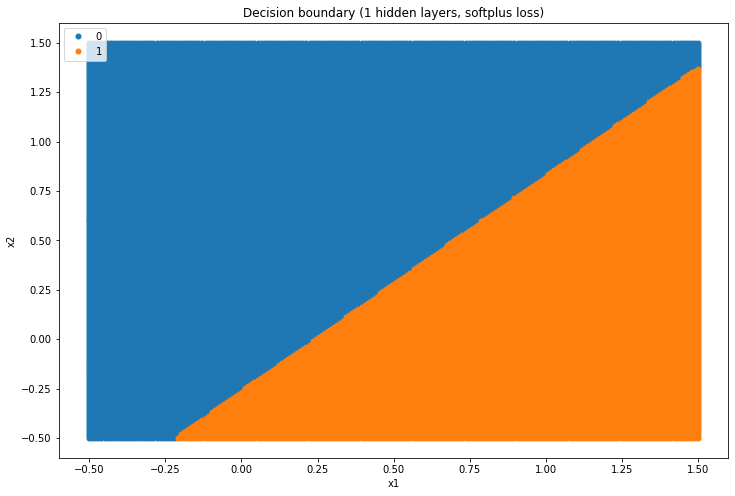

In [9]:
# Part C
train_test_plot(X, y, seed_value = [6524])

--- 3 hidden layers with softplus loss function ---
Training epoch 1 of 10 (loss: 0.7084, accuracy: 62.4500)
Training epoch 2 of 10 (loss: 0.6601, accuracy: 79.8000)
Training epoch 3 of 10 (loss: 0.6424, accuracy: 95.8250)
Training epoch 4 of 10 (loss: 0.6331, accuracy: 97.2500)
Training epoch 5 of 10 (loss: 0.6243, accuracy: 97.0250)
Training epoch 6 of 10 (loss: 0.6156, accuracy: 97.9000)
Training epoch 7 of 10 (loss: 0.6074, accuracy: 97.3250)
Training epoch 8 of 10 (loss: 0.5993, accuracy: 97.7750)
Training epoch 9 of 10 (loss: 0.5913, accuracy: 97.7000)
Training epoch 10 of 10 (loss: 0.5836, accuracy: 97.4250)
Testing batch 1 of 1000 (loss: 0.5844, accuracy: 96.0000)
Testing batch 51 of 1000 (loss: 0.5833, accuracy: 100.0000)
Testing batch 101 of 1000 (loss: 0.5824, accuracy: 98.0000)
Testing batch 151 of 1000 (loss: 0.5891, accuracy: 96.0000)
Testing batch 201 of 1000 (loss: 0.5805, accuracy: 96.0000)
Testing batch 251 of 1000 (loss: 0.5837, accuracy: 98.0000)
Testing batch 301 o

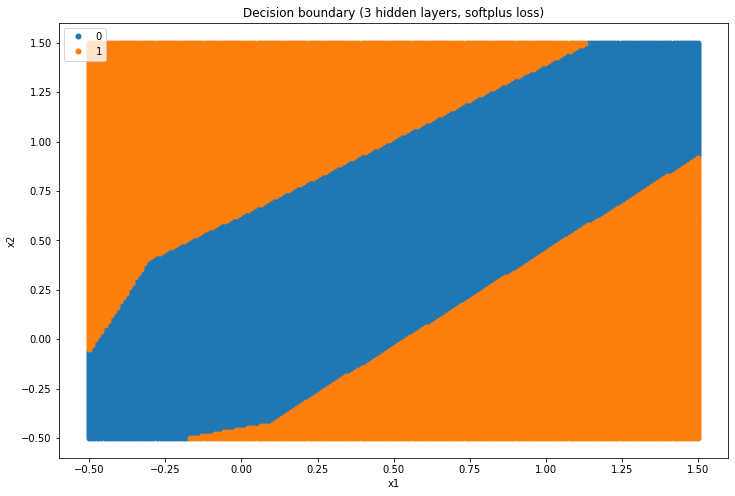


--- 16 hidden layers with softplus loss function ---
Training epoch 1 of 10 (loss: 0.8165, accuracy: 56.1000)
Training epoch 2 of 10 (loss: 0.6537, accuracy: 60.3250)
Training epoch 3 of 10 (loss: 0.6261, accuracy: 74.0000)
Training epoch 4 of 10 (loss: 0.5962, accuracy: 80.7750)
Training epoch 5 of 10 (loss: 0.5726, accuracy: 88.3250)
Training epoch 6 of 10 (loss: 0.5557, accuracy: 92.3000)
Training epoch 7 of 10 (loss: 0.5409, accuracy: 93.2500)
Training epoch 8 of 10 (loss: 0.5272, accuracy: 92.6750)
Training epoch 9 of 10 (loss: 0.5156, accuracy: 92.7750)
Training epoch 10 of 10 (loss: 0.5042, accuracy: 93.5000)
Testing batch 1 of 1000 (loss: 0.5112, accuracy: 98.0000)
Testing batch 51 of 1000 (loss: 0.4842, accuracy: 94.0000)
Testing batch 101 of 1000 (loss: 0.5130, accuracy: 98.0000)
Testing batch 151 of 1000 (loss: 0.5135, accuracy: 96.0000)
Testing batch 201 of 1000 (loss: 0.5087, accuracy: 90.0000)
Testing batch 251 of 1000 (loss: 0.5154, accuracy: 94.0000)
Testing batch 301 

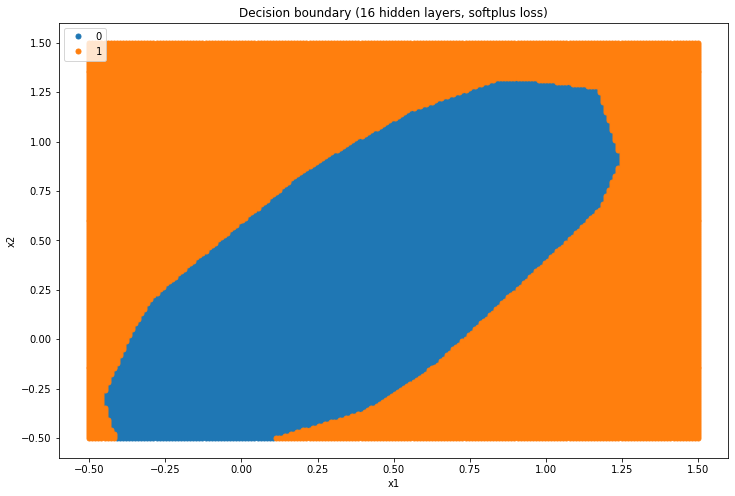


--- 512 hidden layers with softplus loss function ---
Training epoch 1 of 3 (loss: 8.1224, accuracy: 55.9250)
Training epoch 2 of 3 (loss: 0.6802, accuracy: 59.3500)
Training epoch 3 of 3 (loss: 0.6704, accuracy: 60.6000)
Testing batch 1 of 1000 (loss: 0.7002, accuracy: 50.0000)
Testing batch 51 of 1000 (loss: 0.6740, accuracy: 50.0000)
Testing batch 101 of 1000 (loss: 0.6819, accuracy: 50.0000)
Testing batch 151 of 1000 (loss: 0.7154, accuracy: 32.0000)
Testing batch 201 of 1000 (loss: 0.7140, accuracy: 42.0000)
Testing batch 251 of 1000 (loss: 0.6785, accuracy: 58.0000)
Testing batch 301 of 1000 (loss: 0.7021, accuracy: 48.0000)
Testing batch 351 of 1000 (loss: 0.6682, accuracy: 40.0000)
Testing batch 401 of 1000 (loss: 0.6371, accuracy: 62.0000)
Testing batch 451 of 1000 (loss: 0.6461, accuracy: 56.0000)
Testing batch 501 of 1000 (loss: 0.7089, accuracy: 54.0000)
Testing batch 551 of 1000 (loss: 0.7400, accuracy: 34.0000)
Testing batch 601 of 1000 (loss: 0.6918, accuracy: 40.0000)


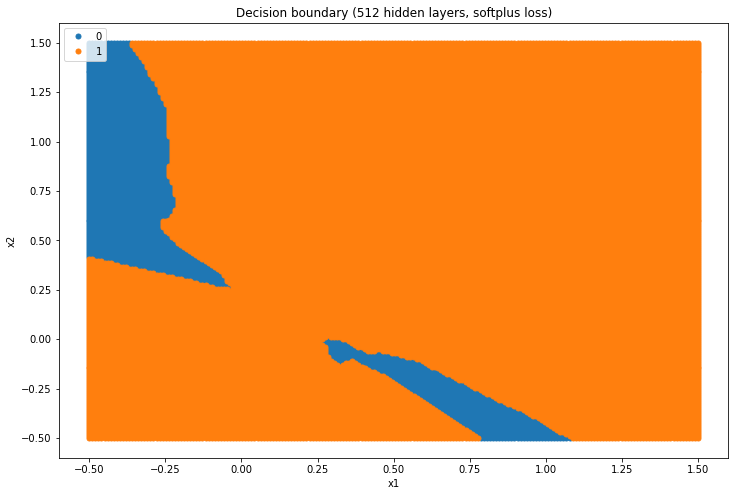

In [10]:
# Part D
train_test_plot(X, y, hidden_layers = [3, 16, 512], epochs = [10, 10, 3], seed_value = [6524, 3528, 7832])

The results show that performance varies with the number of hidden layers:
*   1 is inadequate (accuracy of 64.6%), because more than one decision boundary is needed to correctly classify the XOR
*   3 performs best (accuracy of 97.9%)
*   16 also performs well (accuracy of 93.5%), but it can be seen that 3 boundaries are likely sufficient as no additional benefit is derived by having 16 instead of 3
*   512 does not perform as well as 3 or 16 (accuracy of 47.8%, worse than random chance), likely due to overfitting





--- 3 hidden layers with cce loss function ---
Training epoch 1 of 10 (loss: 0.7081, accuracy: 62.4500)
Training epoch 2 of 10 (loss: 0.6599, accuracy: 79.8000)
Training epoch 3 of 10 (loss: 0.6421, accuracy: 95.8250)
Training epoch 4 of 10 (loss: 0.6328, accuracy: 97.2500)
Training epoch 5 of 10 (loss: 0.6240, accuracy: 97.0250)
Training epoch 6 of 10 (loss: 0.6154, accuracy: 97.9000)
Training epoch 7 of 10 (loss: 0.6071, accuracy: 97.3250)
Training epoch 8 of 10 (loss: 0.5991, accuracy: 97.7750)
Training epoch 9 of 10 (loss: 0.5910, accuracy: 97.7000)
Training epoch 10 of 10 (loss: 0.5834, accuracy: 97.4250)
Testing batch 1 of 1000 (loss: 0.5841, accuracy: 96.0000)
Testing batch 51 of 1000 (loss: 0.5830, accuracy: 100.0000)
Testing batch 101 of 1000 (loss: 0.5821, accuracy: 98.0000)
Testing batch 151 of 1000 (loss: 0.5889, accuracy: 96.0000)
Testing batch 201 of 1000 (loss: 0.5803, accuracy: 96.0000)
Testing batch 251 of 1000 (loss: 0.5835, accuracy: 98.0000)
Testing batch 301 of 100

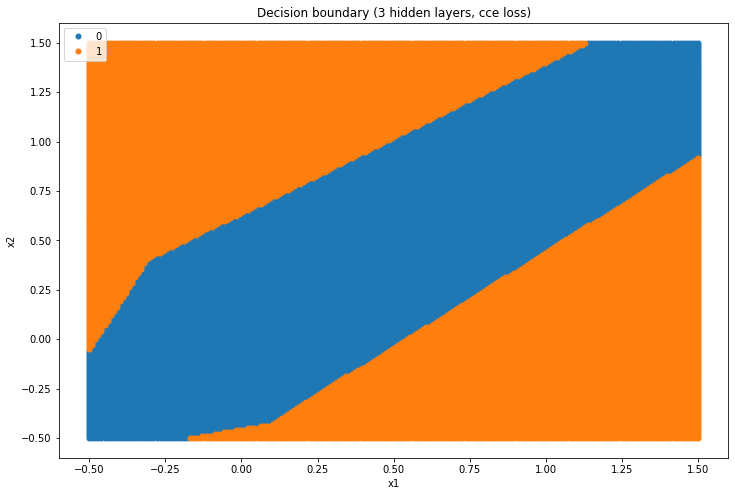


--- 16 hidden layers with cce loss function ---
Training epoch 1 of 10 (loss: 0.8149, accuracy: 56.1000)
Training epoch 2 of 10 (loss: 0.6534, accuracy: 60.3250)
Training epoch 3 of 10 (loss: 0.6259, accuracy: 74.0000)
Training epoch 4 of 10 (loss: 0.5960, accuracy: 80.7750)
Training epoch 5 of 10 (loss: 0.5724, accuracy: 88.3250)
Training epoch 6 of 10 (loss: 0.5554, accuracy: 92.3000)
Training epoch 7 of 10 (loss: 0.5407, accuracy: 93.2500)
Training epoch 8 of 10 (loss: 0.5269, accuracy: 92.6750)
Training epoch 9 of 10 (loss: 0.5154, accuracy: 92.7750)
Training epoch 10 of 10 (loss: 0.5039, accuracy: 93.5000)
Testing batch 1 of 1000 (loss: 0.5110, accuracy: 98.0000)
Testing batch 51 of 1000 (loss: 0.4840, accuracy: 94.0000)
Testing batch 101 of 1000 (loss: 0.5128, accuracy: 98.0000)
Testing batch 151 of 1000 (loss: 0.5133, accuracy: 96.0000)
Testing batch 201 of 1000 (loss: 0.5085, accuracy: 90.0000)
Testing batch 251 of 1000 (loss: 0.5151, accuracy: 94.0000)
Testing batch 301 of 10

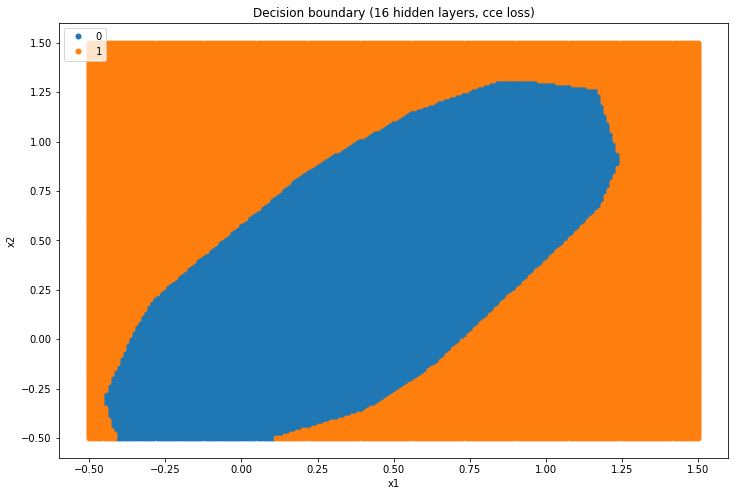


--- 512 hidden layers with cce loss function ---
Training epoch 1 of 3 (loss: 1.3959, accuracy: 55.9250)
Training epoch 2 of 3 (loss: 0.6799, accuracy: 59.3500)
Training epoch 3 of 3 (loss: 0.6701, accuracy: 60.6000)
Testing batch 1 of 1000 (loss: 0.7000, accuracy: 50.0000)
Testing batch 51 of 1000 (loss: 0.6738, accuracy: 50.0000)
Testing batch 101 of 1000 (loss: 0.6817, accuracy: 50.0000)
Testing batch 151 of 1000 (loss: 0.7151, accuracy: 32.0000)
Testing batch 201 of 1000 (loss: 0.7137, accuracy: 42.0000)
Testing batch 251 of 1000 (loss: 0.6782, accuracy: 58.0000)
Testing batch 301 of 1000 (loss: 0.7018, accuracy: 48.0000)
Testing batch 351 of 1000 (loss: 0.6680, accuracy: 40.0000)
Testing batch 401 of 1000 (loss: 0.6369, accuracy: 62.0000)
Testing batch 451 of 1000 (loss: 0.6459, accuracy: 56.0000)
Testing batch 501 of 1000 (loss: 0.7086, accuracy: 54.0000)
Testing batch 551 of 1000 (loss: 0.7397, accuracy: 34.0000)
Testing batch 601 of 1000 (loss: 0.6916, accuracy: 40.0000)
Testi

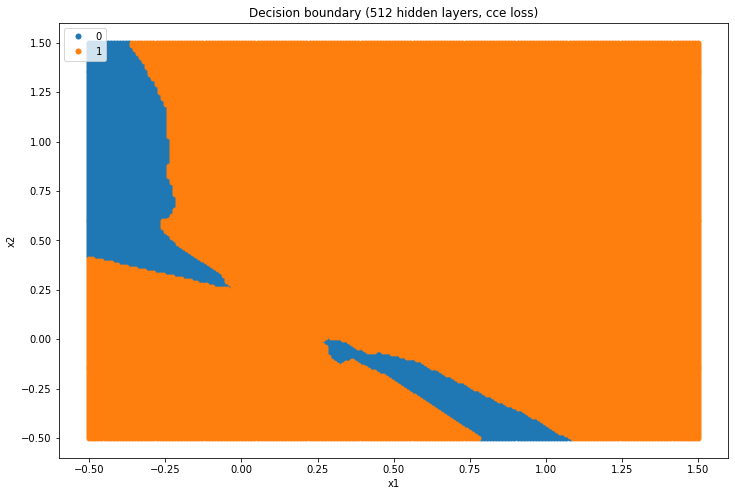

In [11]:
# Part E
train_test_plot(X, y, loss_function = cce, hidden_layers = [3, 16, 512], epochs = [10, 10, 3], seed_value = [6524, 3528, 7832])

In [12]:
# Part F
data3 = pd.DataFrame(np.zeros((5000, 4)), columns=['x1', 'x2', 'x3', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data3.index)):
    x1 = 1.0 * random.randint(0, 1)
    x2 = 1.0 * random.randint(0, 1)
    x3 = 1.0 * random.randint(0, 1)
    y_3 = 1.0 * np.logical_xor(np.logical_xor(x1 == 1, x2 == 1), x3 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    x3 = x3 + 0.15 * np.random.normal()
    data3.iloc[i,0] = x1
    data3.iloc[i,1] = x2
    data3.iloc[i,2] = x3
    data3.iloc[i,3] = y_3
        
data3.head()

# set X (training data) and y (target variable)
cols = data3.shape[1]
X3 = data3.iloc[:,0:cols-1]
y3 = data3.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X3 = np.matrix(X3.values)
y3 = np.matrix(y3.values)

# Train and test the network
train_test_plot(X3, y3, hidden_layers = [3, 16, 512], epochs = [10, 10, 3], seed_value = [6524, 3528, 7832])

--- 3 hidden layers with softplus loss function ---
Training epoch 1 of 10 (loss: 0.7314, accuracy: 45.1000)
Training epoch 2 of 10 (loss: 0.6994, accuracy: 44.3000)
Training epoch 3 of 10 (loss: 0.6960, accuracy: 47.5500)
Training epoch 4 of 10 (loss: 0.6946, accuracy: 46.8000)
Training epoch 5 of 10 (loss: 0.6938, accuracy: 48.7500)
Training epoch 6 of 10 (loss: 0.6932, accuracy: 49.5500)
Training epoch 7 of 10 (loss: 0.6931, accuracy: 52.2000)
Training epoch 8 of 10 (loss: 0.6929, accuracy: 52.1500)
Training epoch 9 of 10 (loss: 0.6928, accuracy: 52.4500)
Training epoch 10 of 10 (loss: 0.6927, accuracy: 52.6750)
Testing batch 1 of 1000 (loss: 0.6938, accuracy: 52.0000)
Testing batch 51 of 1000 (loss: 0.6965, accuracy: 48.0000)
Testing batch 101 of 1000 (loss: 0.7024, accuracy: 46.0000)
Testing batch 151 of 1000 (loss: 0.6888, accuracy: 56.0000)
Testing batch 201 of 1000 (loss: 0.6995, accuracy: 34.0000)
Testing batch 251 of 1000 (loss: 0.7037, accuracy: 44.0000)
Testing batch 301 of

--- 16 hidden layers with softplus loss function ---
Training epoch 1 of 10 (loss: 1.1256, accuracy: 35.5000)
Training epoch 2 of 10 (loss: 0.6564, accuracy: 61.5000)
Training epoch 3 of 10 (loss: 0.6141, accuracy: 75.8333)
Training epoch 4 of 10 (loss: 0.6039, accuracy: 72.8333)
Training epoch 5 of 10 (loss: 0.6001, accuracy: 69.1667)
Training epoch 6 of 10 (loss: 0.5968, accuracy: 69.6667)
Training epoch 7 of 10 (loss: 0.5943, accuracy: 69.8333)
Training epoch 8 of 10 (loss: 0.5916, accuracy: 69.6667)
Training epoch 9 of 10 (loss: 0.5886, accuracy: 70.5000)
Training epoch 10 of 10 (loss: 0.5861, accuracy: 70.0000)
Testing batch 1 of 150 (loss: 0.6015, accuracy: 72.0000)
Testing batch 51 of 150 (loss: 0.5710, accuracy: 76.0000)
Testing batch 101 of 150 (loss: 0.5671, accuracy: 74.0000)
Testing complete (loss: 0.5798, accuracy: 74.0000)


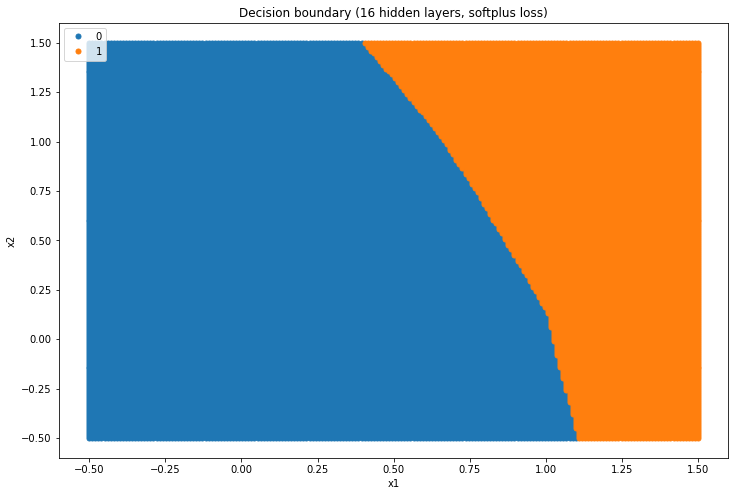

In [13]:
# Part G
#dataHW = pd.read_csv('dataset_flowers_horses.csv')
dataHW = pd.read_csv('dataset_diabetes.csv')

# Keep only a multiple of the batch size
n_drop = len(dataHW) % 50
dataHW.drop(dataHW.tail(n_drop).index, inplace = True)

# Normalize
for k in [0, 1]:
    dataHW.iloc[:,k] = dataHW.iloc[:,k]  / dataHW.iloc[:,k] .abs().max()

# set X (training data) and y (target variable)
cols = dataHW.shape[1]
XHW = dataHW.iloc[:,0:cols-1]
yHW = dataHW.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
XHW = np.matrix(XHW.values)
yHW = np.matrix(yHW.values)

# Test
train_test_plot(XHW, yHW, hidden_layers = [16], seed_value = [6524])

Datasets can be found at the following [Google Drive](https://drive.google.com/drive/folders/1MvBidgMl1mD3SrKkLH7UCQGuTtwmawEB?usp=sharing) location.